## **Introduction to Computer Vision (Fall 2021)**

### **Assignment 3: Crack detection**

Dataset: [download](https://drive.google.com/file/d/1oV7ZAJyaIqQICAR55Zq8Xf9i_nDgSKuh/view?usp=sharing)



### **Introduction**

Concrete structures such as bridge play an important role in ground transportation networks. While it is very labor intensive and dangerous for human to do the crack inspection. However, traditionally, concrete structure inspections are conducted manually by human operators with heavy and expensive mechanical equipment. It is logistically challenging, costly, and dangerous, especially when inspecting the substructure and superstructure in harsh environments that are hard and dangerous to be accessed by human operators. Therefore, it is very meaningful and significant for us to develop a fully autonomous intelligent unmanned aerial system for inspecting large-scale concrete structures and detecting the defects such as cracks. Most importantly, a significant module for UAV intelligent inspection system is to develop computer vision algorithms for processing images captured and detecting cracks and structural damages.

### **Data**
There are two classes only: positive (crack is present on image) and negative. Train images are located in folders named Positive/Negative. Test images are not provided.

Data are color images, each 227 by 227 pixels. There are 18,898 positive training samples and 18,811 negative training samples.



### **Anomaly detection**
Note: you are free to develop your own solution, here are some suggestions only.

You could build a binary classification network for this task, but we suggest you to build anomaly detection framework for solving this task. You can treat either positive images, either negative images as normal data.

Anomalies, also referred to as outliers, are defined as a set of patterns which significantly deviate from the normal or expected pattern.

We suggest you to build a CNN based autoencoder, that will be trained to reproduce normal patterns. The idea is, that the reproduction loss of a normal patterns will be much less than in abnormal patterns.

### **Autoencoder layers**
Here is the basic structure of autoencoder, that we propose to use. You are not obliged to use this one.

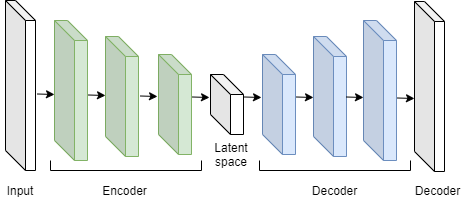

Encoder is a network that downsamples images into some latent space representation. Decoder upsamples from latent space to get the initial image. There are 3 layers in encoder and 3 layers in decoder. Try to play with the latent space size.

We suggest you to use tanh activation function for encoder and decoder layers.

Reconstruction Loss

Autoencoder is trained to minimize the following loss:

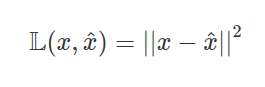

### **decision making**

After training the autoencoder to minimize the reconstruction loss for normal data samples, reconstruction loss threshold *t* is defined to make decision rule for separating normal and abnormal patterns. The full formulation of the anomaly detection using autoencoder can be expressed as follows:

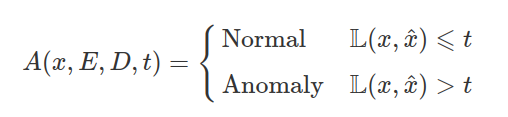

### **Grading policy**
You are free to experiment with data, methods and parameters, but the following things should be reflected in your code:

images of variable lenth should be allowed (make some preprocessing for that)


model will be evaluated using Precision and Recall (for both training dataset, and testing dataset)

USE RANDOM IMAGES FROM THE INTERNET TO TEST YOUR MODEL (10 to 15 images)
DO NOT FORGET TO INCLUDE THESE IMAGES WITH YOUR SUBMISSION

Your script should output predictions for test images in table (ypu can create a file predictions.csv) with the following format: file name, class label


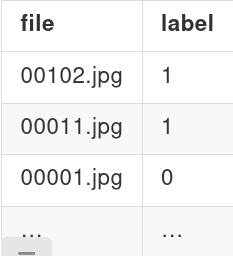



Class labels have the following mapping: positive - 1, negative - 0

**Important:** 0 points if we won’t be able to run your code

**Note:** Code quality will be evaluated. Up to -10% for not readable code.

**Note:** Your are free to use any framework (PyTorch, Keras, TensorFlow …).


In [160]:
import os
import time
import random
import numpy as np

import torch.optim as optim
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

from IPython.display import clear_output
from PIL import Image
from torch.utils.data import DataLoader, Subset, Dataset
from torch.utils.data import random_split
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, CenterCrop

In [161]:
some_transforms = transforms.Compose([
    transforms.CenterCrop(200),
    transforms.ToTensor()
])

data_dir = '/kaggle/input/crackdataset/Dataset'
train_ds = ImageFolder(data_dir, transform=some_transforms)

In [162]:
def show_example(img, label):
    print('Label: ', train_ds.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

In [163]:
show_example(*train_ds[20000])

In [164]:
random_seed = 42
torch.manual_seed(random_seed);

In [165]:
val_size = 3000
train_size = len(train_ds) - val_size

train_ds, val_ds = random_split(train_ds, [train_size, val_size])
len(train_ds), len(val_ds)

In [166]:
batch_size=32

In [167]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [168]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [169]:
show_batch(train_dl)

In [170]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        #Encoder
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))
              
        return x

In [171]:
model = ConvAutoencoder()

In [172]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

In [174]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [175]:
device = get_default_device()
device

In [176]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [177]:
loss_func = nn.MSELoss()
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr)

In [178]:
def train(model, train_loader, optimizer, n_epochs):
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            image, label = batch
            out = model(image)
            loss = loss_func(out, image)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*images.size(0)
        train_loss = train_loss/len(train_loader)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

In [179]:
train(model, train_dl, optimizer, 10)

In [189]:
torch.save(model.state_dict(), 'model.pth')

In [180]:
import seaborn as sns

In [183]:
def decision(threshold, batch):
    images, labels = batch
    outs = model(images)
    losses = []
    for a, b in zip(outs, images):
        loss = loss_func(a, b)
        losses.append(loss)
    results = []
    for l in losses:
        if l <= threshold:
            results.append(0)
        else:
            results.append(1)
    sns.distplot(losses,bins=100,kde=True, color='blue')
    plt.axvline(threshold, 0.0, 10, color='r')
    return results

In [193]:
def precision(labels, predictions):
    TP = 0
    FP = 0
    for i in range(len(predictions)):
        if predictions[i] == 1 and labels[i].item() == 1:
            TP += 1
        elif predictions[i] == 1 and labels[i].item() == 0:
            FP += 1
        else:
            pass
    return TP/(TP+FP)

In [194]:
def recall(labels, predictions):
    TP = 0
    FN = 0
    for i in range(len(predictions)):
        if predictions[i] == 1 and labels[i].item() == 1:
            TP += 1
        elif predictions[i] == 0 and labels[i].item() == 1:
            FN += 1
        else:
            pass
    return TP/(TP+FN)

In [196]:
for batch in val_dl:
    images, labels = batch
    ls = decision(0.00045, batch)
    for a, b in zip(labels, ls):
        print("Label: {}, prediction: {}".format(a.item(), b))
    print("Precision: {}".format(precision(labels, ls)))
    print("Recall: {}".format(recall(labels, ls)))
    break

References: https://analyticsindiamag.com/how-to-implement-convolutional-autoencoder-in-pytorch-with-cuda/